## 선형회귀

In [1]:
import tensorflow as tf

In [2]:
# 선형회귀 모델(wx + b)을 위한 tf.Variable을 선언. linear regression은 차원이 1차원이므로 shape을 1로 지정
W= tf.Variable(tf.random.normal(shape=[1]))
b = tf.Variable(tf.random.normal(shape=[1]))

In [3]:
# 모델 함수 정의
def linear_model(x):
    return W*x + b

In [4]:
#손실함수 정의, MSE 사용
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

In [5]:
# 최적화를 위한 gradient decent optimizer 정의
optimizer = tf.optimizers.SGD(0.01) #stochastic gradient decent 사용한 듯, learning rate 0.01로 설정
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [6]:
# 최적화 함수
def train_step(x,y):
    with tf.GradientTape() as tape:
        y_pred = linear_model(x)
        loss = mse_loss(y_pred, y)
    gradients = tape.gradient(loss, [W,b])
    optimizer.apply_gradients(zip(gradients, [W,b])) # zip은 리스트의 개별 요소들을 인덱스 순서에 맞게 쌍으로 묶어준다.

### training

In [7]:
# 트레이닝을 위한 입력값과 출력값을 준비
x_train = [1,2,3,4]
y_train = [2,4,6,8]

In [8]:
# 경사 하강법 1000번
for i in range(1000):
    train_step(x_train, y_train)

### test

In [9]:
x_test = [3.5,5,5.5,6]

In [10]:
print(linear_model(x_test).numpy())

[ 7.0031505 10.011592  11.014405  12.017219 ]


## Softmax Algorithm

In [11]:
import tensorflow as tf

In [12]:
#MNIST 데이터 다운로드, numpy array 형태로 넘어옴.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [13]:
# 이미지들을 float32 데이터 타입으로 변경
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')

In [14]:
# 28*28 형태의 이미지를 784차원으로 flattening
# 2-dim을 1-dim으로 만들어주는 것. 
x_train, x_test = x_train.reshape([-1,784]), x_test.reshape([-1,784]) # -1은 magic number로 data의 개수를 자동으로 할당함. 
                                                                      # 60000개와 10000개로 자동으로 맞추어줌

In [15]:
# [0, 255] 사이의 값을 [0,1] 사이의 값으로 Normalize
x_train, x_test = x_train / 255., x_test / 255.

In [16]:
# 레이블 데이터에 one-hot encoding
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

In [17]:
# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옴
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # tf.data.Dataset는 데이터를 미니배치로 묶기 쉽도록
                                                                    # 추상화해 놓은 클래스
train_data = train_data.repeat().shuffle(60000).batch(100) # batch 100개씩 묶겠다.
train_data_iter = iter(train_data) # 추후 next 함수와 상호작용

In [18]:
# tf.keras,Model을 이용해서 Softmax Regression 모델 정의

# tf.keras.Model을 상속받는 class 생성
class SoftmaxRegression(tf.keras.Model):
    def __init__(self):
        super(SoftmaxRegression, self).__init__() # 케라스 모델의 기본적인 생성자 부분을 재호출
        # 모델 building
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dens
        self.softmax_layer = tf.keras.layers.Dense(10, # 넘기고자 하는 output dimension.
                                                  activation=None,
                                                  kernel_initializer='zeros', # W와 b의 초기값을 0으로 지정.
                                                  bias_initializer='zeros')
    def call(self, x):
        logits = self.softmax_layer(x)
        
        return tf.nn.softmax(logits)

In [19]:
# cross-entropy 손실함수 정의
def cross_entropy_loss(y_pred, y):
    return tf.reduce_mean(-tf.reduce_sum(y*tf.math.log(y_pred), axis=[1])) # 손실함수 직접 정의
    #return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logtis, labels=y)) # 이미 정의돼 있는 함수. 
                                                                                        # 이 경우, call함수의 반환값이 
                                                                                        #softmax함수가 씌워진 값이아닌
                                                                                        #raw logit값이어야 한다.
    # tf.nn.softmax_cross_entropy_with_logits API를 이용한 구현

In [20]:
# 최적화를 위한 그라디언트 디센트 optimizer 정의
optimizer = tf.optimizers.SGD(0.5)

In [21]:
# 최적화 함수
def train_step(model, x,y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = cross_entropy_loss(y_pred, y)
    gradients = tape.gradient(loss, model.trainable_variables) # trainable_variables를 사용할 경우, 
                                                                # 이전에 만든 모델의 모든 구조를 반환해줌
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [22]:
# 모델의 정확도 출력 함수
def compute_accuracy(y_pred, y):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1)) # argmax를 사용해서 가장 큰 값을 prediction 값으로 확정해주는 것.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [23]:
# SoftmazRegression 모델 선언
SoftmaxRegression_model = SoftmaxRegression()

In [24]:
# 1000번 반복으로 최적화
for i in range(1000):
    batch_xs, batch_ys = next(train_data_iter)
    train_step(SoftmaxRegression_model, batch_xs, batch_ys)

In [25]:
# 정확도 출력
print("정확도(Accuracy): %f " % compute_accuracy(SoftmaxRegression_model(x_test), y_test))

정확도(Accuracy): 0.918900 


## ANN

In [26]:
import tensorflow as tf

# MNIST 데이터를 다운로드 합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 이미지들을 float32 데이터 타입으로 변경합니다.
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# [0, 255] 사이의 값을 [0, 1]사이의 값으로 Normalize합니다.
x_train, x_test = x_train / 255., x_test / 255.
# 레이블 데이터에 one-hot encoding을 적용합니다.
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

In [27]:
# 학습을 위해 설정값 정의
learning_rate = 0.001
num_epochs = 30 # 학습횟수
batch_size = 256 # 배치개수
display_step = 1 # 손실함수 출력 주기
input_size = 784
hidden1_size = 256
hidden2_size = 256
output_size = 10

In [28]:
# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옴
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(60000).batch(batch_size)

In [29]:
def random_normal_intializer_with_stddev_1():
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None)

In [30]:
# tf.keras.Model을 이용해서 ANN모델을 정의
class ANN(tf.keras.Model):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(hidden1_size,
                                                   activation='relu',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        self.hidden_layer_2 = tf.keras.layers.Dense(hidden2_size,
                                                   activation='relu',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        self.output_layer = tf.keras.layers.Dense(output_size,
                                                   activation=None,
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        
    def call(self, x):
        H1_output = self.hidden_layer_1(x)
        H2_output = self.hidden_layer_2(H1_output)
        logits = self.output_layer(H2_output)

        return logits

In [31]:
# cross-entropy 손실함수 정의
def cross_entropy_loss(logits, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

In [32]:
# 최적화를 위한 Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate)

In [33]:
# 최적화 함수
def train_step(model, x,y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = cross_entropy_loss(y_pred, y)
    gradients = tape.gradient(loss, model.trainable_variables) # trainable_variables를 사용할 경우, 
                                                                # 이전에 만든 모델의 모든 구조를 반환해줌
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [34]:
# 모델의 정확도 출력 함수
def compute_accuracy(y_pred, y):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1)) # argmax를 사용해서 가장 큰 값을 prediction 값으로 확정해주는 것.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [35]:
# ANN 모델 선언
ANN_model = ANN()

In [36]:
# 지정된 횟수만큼 최적화 수행
for epoch in range(num_epochs):
    average_loss = 0.
    total_batch = int(x_train.shape[0] / batch_size)
    
    # 모든 batch에 대해 최적화 수행
    for batch_x, batch_y in train_data:
        #옵티마이저를 실행해서 파라미터 업데이트
        _, current_loss = train_step(ANN_model, batch_x, batch_y), cross_entropy_loss(ANN_model(batch_x), batch_y)
        
        # 평균 손실을 측정
        average_loss += current_loss / total_batch
        
    # 지정된 epoch마다 학습 결과 출력
    if epoch % display_step == 0:
        print("반복(Epoch): %d, 손실 함수(Loss): %f" % ((epoch +1), average_loss))

#정확도 출력
print("정확도(Accuracy): %f " % compute_accuracy(ANN_model(x_test), y_test))

반복(Epoch): 1, 손실 함수(Loss): 277.867828
반복(Epoch): 2, 손실 함수(Loss): 61.296265
반복(Epoch): 3, 손실 함수(Loss): 39.818485
반복(Epoch): 4, 손실 함수(Loss): 29.075478
반복(Epoch): 5, 손실 함수(Loss): 22.508543
반복(Epoch): 6, 손실 함수(Loss): 17.982603
반복(Epoch): 7, 손실 함수(Loss): 14.631808
반복(Epoch): 8, 손실 함수(Loss): 11.954827
반복(Epoch): 9, 손실 함수(Loss): 9.843960
반복(Epoch): 10, 손실 함수(Loss): 8.167468
반복(Epoch): 11, 손실 함수(Loss): 6.681476
반복(Epoch): 12, 손실 함수(Loss): 5.526685
반복(Epoch): 13, 손실 함수(Loss): 4.613533
반복(Epoch): 14, 손실 함수(Loss): 3.700699
반복(Epoch): 15, 손실 함수(Loss): 2.985919
반복(Epoch): 16, 손실 함수(Loss): 2.459886
반복(Epoch): 17, 손실 함수(Loss): 1.964166
반복(Epoch): 18, 손실 함수(Loss): 1.614003
반복(Epoch): 19, 손실 함수(Loss): 1.309060
반복(Epoch): 20, 손실 함수(Loss): 1.076161
반복(Epoch): 21, 손실 함수(Loss): 0.762862
반복(Epoch): 22, 손실 함수(Loss): 0.576540
반복(Epoch): 23, 손실 함수(Loss): 0.464878
반복(Epoch): 24, 손실 함수(Loss): 0.387580
반복(Epoch): 25, 손실 함수(Loss): 0.279718
반복(Epoch): 26, 손실 함수(Loss): 0.215415
반복(Epoch): 27, 손실 함수(Loss): 0.189472
반

## AutoEncoder

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# MNIST 데이터를 다운로드 합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 이미지들을 float32 데이터 타입으로 변경합니다.
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# [0, 255] 사이의 값을 [0, 1]사이의 값으로 Normalize합니다.
x_train, x_test = x_train / 255., x_test / 255.

In [39]:
# 학습에 필요한 설정값 저장
# 학습을 위해 설정값 정의
learning_rate = 0.02
training_epochs = 50 # 학습횟수
batch_size = 256 # 배치개수
display_step = 1 # 손실함수 출력 주기
example_to_show = 10 # 보여줄 MNIST Reconstruction 이미지 개수
input_size = 784
hidden1_size = 256
hidden2_size = 128

In [40]:
# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옴
train_data = tf.data.Dataset.from_tensor_slices(x_train) # unsupervised learning이기 때문에 y_train이 필요 없음!
train_data = train_data.shuffle(60000).batch(batch_size)

In [41]:
def random_normal_intializer_with_stddev_1():
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None)

In [42]:
# tf.keras.Model 을 이용해서 Autoencoder모델 정의
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # 인코딩 - 784 --> 256 --> 128
        self.hidden_layer_1 = tf.keras.layers.Dense(hidden1_size,
                                                   activation='sigmoid',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        self.hidden_layer_2 = tf.keras.layers.Dense(hidden2_size,
                                                   activation='sigmoid',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        # 디코딩 128 --> 256 --> 784
        self.hidden_layer_3 = tf.keras.layers.Dense(hidden1_size,
                                                   activation='sigmoid',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
        self.output_layer = tf.keras.layers.Dense(input_size,
                                                   activation='sigmoid',
                                                   kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                   bias_initializer=random_normal_intializer_with_stddev_1())
    def call(self, x):
        H1_output = self.hidden_layer_1(x)
        H2_output = self.hidden_layer_2(H1_output)
        H3_output = self.hidden_layer_3(H2_output)
        reconstructed_x = self.output_layer(H3_output)

        return reconstructed_x
        

In [43]:
# MSE 손실함수 정의
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.pow(y_true - y_pred, 2))

In [44]:
# optimizer 정의
optimizer = tf.optimizers.RMSprop(learning_rate)

In [45]:
# 최적화
def train_step(model, x):
    with tf.GradientTape() as tape:
        y_true = x
        y_pred = model(x)
        loss = mse_loss(y_pred, y_true)
    gradients = tape.gradient(loss, model.trainable_variables) # trainable_variables를 사용할 경우, 
                                                                # 이전에 만든 모델의 모든 구조를 반환해줌
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [46]:
# 모델 선언
AutoEncoder_model = AutoEncoder()

In [47]:
for epoch in range(training_epochs):
    for batch_x in train_data:
        _, current_loss = train_step(AutoEncoder_model, batch_x), mse_loss(AutoEncoder_model(batch_x), batch_x)
    
    if epoch  % display_step == 0:
        print("반복(Epoch): %d, 손실함수(Loss): %f" % ((epoch + 1), current_loss))

반복(Epoch): 1, 손실함수(Loss): 0.187886
반복(Epoch): 2, 손실함수(Loss): 0.182231
반복(Epoch): 3, 손실함수(Loss): 0.178720
반복(Epoch): 4, 손실함수(Loss): 0.179544
반복(Epoch): 5, 손실함수(Loss): 0.174285
반복(Epoch): 6, 손실함수(Loss): 0.169742
반복(Epoch): 7, 손실함수(Loss): 0.168718
반복(Epoch): 8, 손실함수(Loss): 0.168720
반복(Epoch): 9, 손실함수(Loss): 0.163348
반복(Epoch): 10, 손실함수(Loss): 0.158542
반복(Epoch): 11, 손실함수(Loss): 0.157211
반복(Epoch): 12, 손실함수(Loss): 0.159805
반복(Epoch): 13, 손실함수(Loss): 0.152371
반복(Epoch): 14, 손실함수(Loss): 0.153542
반복(Epoch): 15, 손실함수(Loss): 0.152338
반복(Epoch): 16, 손실함수(Loss): 0.150553
반복(Epoch): 17, 손실함수(Loss): 0.146694
반복(Epoch): 18, 손실함수(Loss): 0.146913
반복(Epoch): 19, 손실함수(Loss): 0.144389
반복(Epoch): 20, 손실함수(Loss): 0.140764
반복(Epoch): 21, 손실함수(Loss): 0.140541
반복(Epoch): 22, 손실함수(Loss): 0.138056
반복(Epoch): 23, 손실함수(Loss): 0.139517
반복(Epoch): 24, 손실함수(Loss): 0.136527
반복(Epoch): 25, 손실함수(Loss): 0.135074
반복(Epoch): 26, 손실함수(Loss): 0.136485
반복(Epoch): 27, 손실함수(Loss): 0.128877
반복(Epoch): 28, 손실함수(Loss): 0.132487
반

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_968\2465294082.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


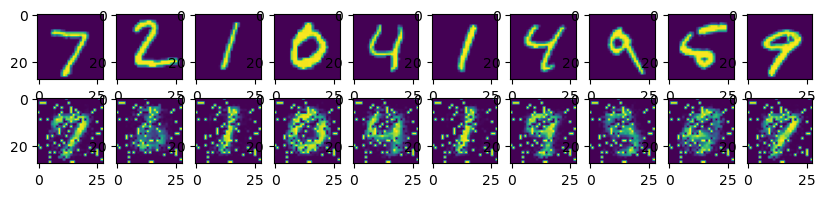

In [53]:
# 테스트 데이터로 Reconstruction을 수행합니다.
reconstructed_result = AutoEncoder_model(x_test[:example_to_show])
# 원본 MNIST 데이터와 Reconstruction 결과를 비교합니다.
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(example_to_show):
  a[0][i].imshow(np.reshape(x_test[i], (28, 28)))
  a[1][i].imshow(np.reshape(reconstructed_result[i], (28, 28)))
f.savefig('reconstructed_mnist_image.png')  # reconstruction 결과를 png로 저장합니다.
f.show()